Change log
-----------

| Time        | Changes                              | Author |
|-------------|--------------------------------------|--------|
| 28/Jan/2015 | First draft                          | weifu  |
| 09/2020     | Make script compatible with Python 3 | Weifu  |
| 08/2024     | Minor description improvement        | Weifu  |


references 
================
1. Yang Bo, Topology investigation of front end DC/DC converter for distributed power system, Phd dissetation
2. TI slup263, designing an LLC resonant half-bridge power converter
3. Fairchild AN-4151, Half-Bridge LLC Resonant Converter Design Using FSFR-Series Fairchild Power Switch (FPS™) 

Intro
==============
LLC topology is widely used for its high conversion efficiency, excellent EMI performance from soft-switching, and the ability to reduce converter size by increasing operating frequency. However, optimizing LLC converters is challenging due to the many factors affecting performance and the need to balance efficiency, reliability, and safety.

This document serves for several different purposes:

* **LLC Characteristics**: Describing the general characteristics of LLC converters based on key parameters such as load (equivalent quality factor), operating frequency, and inductance ratio.
* **Design and Optimization**: Designing and optimizing the LLC converter's resonant tank to balance performance trade-offs among conversion efficiency, operating frequency range, and the tendency to enter the capacitive operation zone.
* **Design Verification**: Verifying the feasibility of the design by assessing the performance at the operating point.


In [1]:
# -*- coding: utf-8 -*-
# calculation environment setup
%matplotlib inline
import math
import sys, os, struct, ctypes

import numpy as np
import scipy as sp
import matplotlib as mpl

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

General LLC characteristics
==================
The LLC converter is the most widely used resonant converter that regulates the output through pulse frequency modulation (PFM), unlike conventional DC-DC converters that use pulse width modulation (PWM). Therefore, the output frequency characteristic, known as the gain curve, is the most important aspect that reveals the steady-state operating point.

This section aims to analyze the general characteristics of LLC resonant converters by normalizing all related parameters.

![LLC equivalent circuit](./images/FHA-LLC-eq-model.png  "LLC equivalent model" )

Extract fundamental variables
--------------

The table below deducts the formulas and key variables for the *half-bridge* configured LLC converters. 

| Variable                                                                                                                                                                                                                                                                  | Definition                                                                                                                               | Remark                                                           |
|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------|
|                                                                                                                           The input bus voltage                                                                                                                           | $V_{DC}$                                                                                                                                 |                                                                  |
|                                                                                                                          The square-wave voltage                                                                                                                          | $\ v_{sq}(t) = \begin{cases} {V_{DC} \over 2},  \|t\| < {T_s \over 2} \\ -{V_{DC} \over 2},  {T_s \over 2} < \|t\| \leq T_s \end{cases}$ |                                                                  |
|                                                                                                     The input side fundamental voltage <br>of the square wave voltage                                                                                                     | $V_{ge}(t) = \frac{2}{\pi}\times V_{DC}\times \sin(2\pi f_{sw}t)$                                                                        |                                                                  |
| The RMS input voltage                                                                                                                                                                                                                                                     | $V_{ge} = \frac{\sqrt{2}}{\pi} \times V_{DC}$                                                                                            |                                                                  |
| The output side fundamental voltage <br>of the square wave voltage                                                                                                                                                                                                        | $V_{oe}(t) = \frac{4}{\pi}\times n \times V_{o} \times sin(2\pi f_{sw}t - \varphi_{v})$                                                  | $\varphi_{v}$ is the phase diff<br>between $V_{oe}$ and $V_{ge}$ |
| The RMS output voltage                                                                                                                                                                                                                                                    | $V_{oe}= \frac{2\sqrt{2}}{\pi}\times n \times V_{o}$                                                                                     |                                                                  |
| While the fundamental harmonic of the voltage is extracted,<br> the output current is already close to a sinusoidal before approximation.<br>It is assumed that the average equivalent output current, $\left\| I_{oe} \right\|$, <br>represents the output current $I_o$ | $i_{oe}(t)=\frac{\pi}{2}\times \frac{1}{n}\times I_{o} \times \sin(2\pi f_{sw}t - \varphi_{i}) $                                         | $\varphi_{i}$ is the phase angle between $i_{oe}$ and $v_{oe}$   |
| The RMS output current                                                                                                                                                                                                                                                    | $I_{oe}= \frac{\pi}{2\sqrt{2}}\times \frac{1}{n} \times I_{o}$                                                                           |                                                                  |
| The AC equivalent load resistance                                                                                                                                                                                                                                         | $R_e = \frac{V_{oe}}{I_{oe}}=\frac{8\times n^2}{\pi ^2}\times R_L$                                                                       | Where $R_L=\frac{V_o}{I_o}$                                      |
| Resonant tank impedance                                                                                                                                                                                                                                                   | $Z_r = \sqrt{\frac{L_r}{C_r}}$                                                                                                           |                                                                  |




Electrical components
-----------------

| Variable                              | Definition                          |
|---------------------------------------|-------------------------------------|
| The angular frequency                 | $\omega_{sw}=2\pi f_{sw}$           |
| The impedance of resonant capacitor   | $X_{C_r}=\frac{1}{\omega C_r}$      |
| The impedance of resonant inductor    | $X_{L_r}=\omega L_r$                |
| The inpedance of magnitizing inductor | $X_{L_m}=\omega L_m$                |
| The magnitizing current               | $I_m=\frac{V_{oe}}{\omega L_m}$     |
| The circulating RMS current           | $I_r = \sqrt{{I_m}^2 + {I_{oe}}^2}$ |


Obtain the converter gain
------------------

The converter DC gain is,
$$M_{g\_{DC}} = \frac{nV_o}{V_{in} /2} \approx 
M_{g\_{sw}} = \frac{V_{so}}{V_{sg}} \approx  
M_{g\_{AC}} =\frac{V_{oe}}{V_{ge}} = M_g$$

The First Harmonic Approximation (FHA) gain is, 

$$M_g = \frac{V_{oe}}{V_{ge}}
= \left| \frac{jX_{L_m}||R_e}
        {(jX_{L_m}||R_e) + j(X_{L_r} - X_{C_r})}\right|
= \left| \frac{(j\omega L_m)||R_e}
        {(j\omega L_m)||R_e + j\omega L_r + \frac{1}{j\omega C_r}} \right|$$

Normalized voltage gain
-------------------------

| Variable                                          | Definition                                            |                                                                                               |
|---------------------------------------------------|-------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| The resonant frequency                            | $f_0 = \frac{1}{2\pi \sqrt{L_r C_r}}$                 |                                                                                               |
| The pole frequency                                | $f_p = \frac{1}{2\pi \sqrt{(L_r + L_m) C_r}}$         | The peak resonant frequency $f_{c0}$ is load related,<br>and locates between $f_0$ and $f_p$. |
| The frequency normalization base                  | $f_n = \frac{f_{sw}}{f_0}$                            |                                                                                               |
| Inductance ratio                                  | $L_n = \frac{L_m}{L_r}$                               |                                                                                               |
| The quality factor of the series resonant circuit | $Q_e = \frac{Z_r}{R_e} = \frac{\sqrt{L_r /C_r}}{R_e}$ |                                                                                               |


The gain function is <span style="color:red">normalized</span> to,
$$\begin{align}
M_g &=\left|\frac{L_n\times {f_n}^2}
  {\left[\left(L_n+1\right)\times {f_n}^2-1\right] + 
   j\left[\left({f_n}^2-1\right)\times f_n\times Q_e\times L_n\right]}\right| \\
    &= \frac{L_n {f_n}^2}
       {\sqrt{1 +
               [{L_n}^2 {Q_e}^2 - 2(1+L_n)]\cdot {f_n}^2 +
               [(1+L_n)^2 - 2{L_n}^2 {Q_e}^2]\cdot{f_n^4} + 
               {Q_e}^2 {L_n}^2 {f_n}^6} }
\end{align}$$

In [2]:
# The following 2 equations generate the same result

# The voltage gain FHA equation form 1
# Mg = lambda fn,Qe,Ln: np.abs((Ln*fn*fn)/(((Ln+1)*fn*fn - 1) + (fn*fn -1)*fn*Qe*Ln*1j))

# The voltage gain FHA equation form 2
Mg = lambda fn,Qe,Ln: Ln * fn**2 /(np.sqrt(1 + (Ln**2 * Qe**2 - 2*(1+Ln))*fn**2 +
               ((1+Ln)**2 - 2*Ln**2 * Qe**2) * fn**4 + 
               Qe**2 * Ln**2 * fn**6 ) )

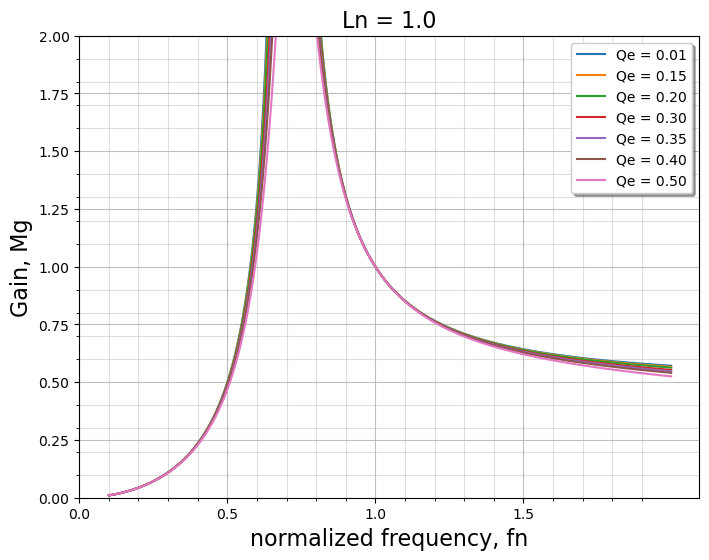

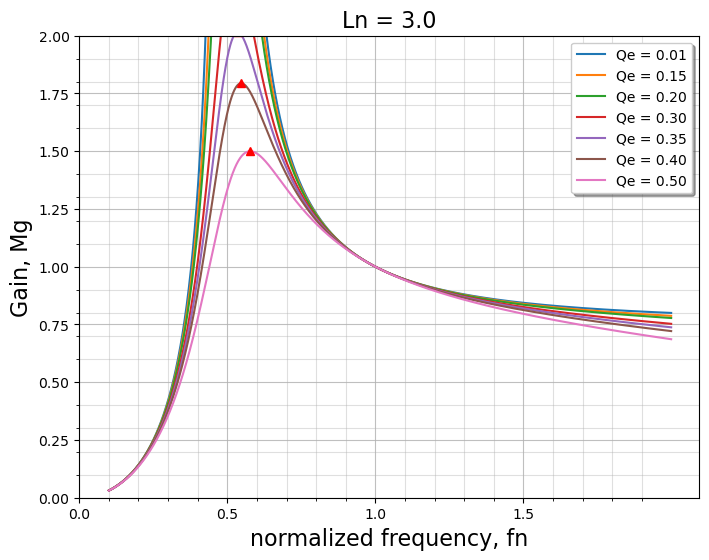

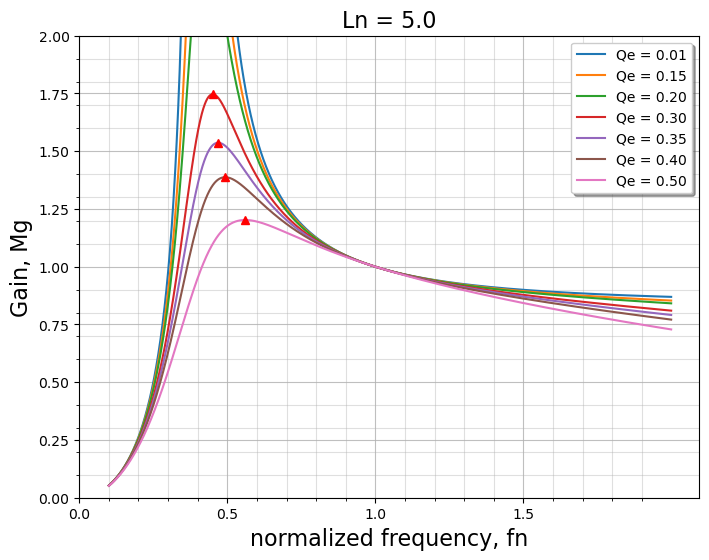

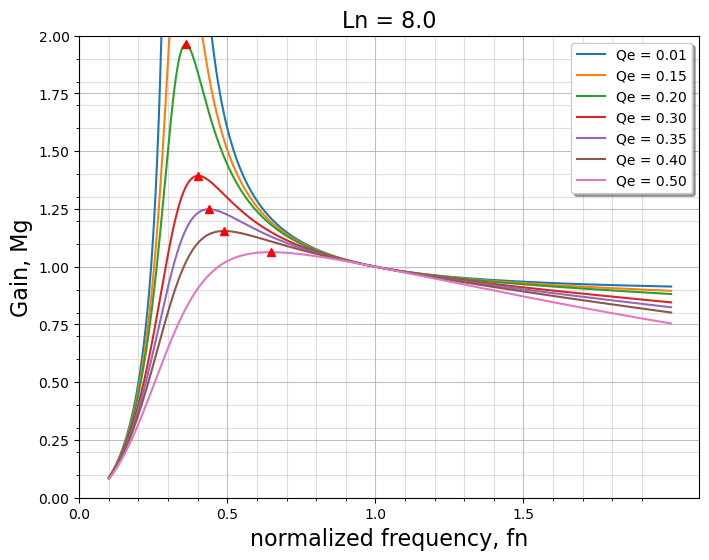

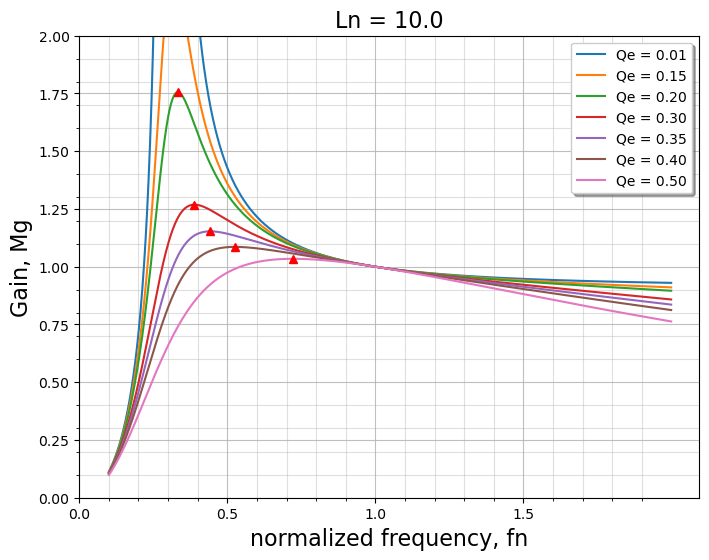

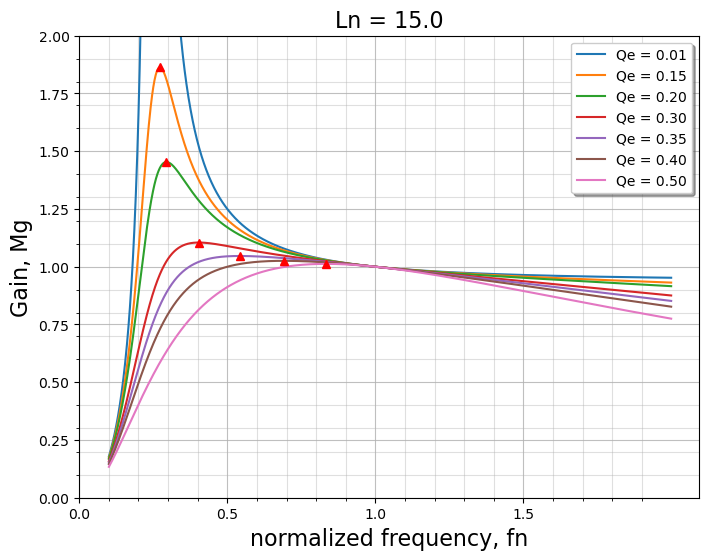

In [3]:
# The gain will be tested on the following parameters
fn = np.arange(0.1, 2, 0.001)
Ln = [1, 3, 5, 8, 10, 15]
Qe = [0.01, 0.15, 0.2, 0.3, 0.35, 0.4, 0.5]

pk_ind = []
pks = []

# The loop is to generate the gain curve figures
# gain against fn is plotted for different Ln and Qe
for i, Ln_i in enumerate(Ln):
    plt1 = plt.figure(i+1,figsize=(8,6))
    ax = plt1.add_subplot(111)
    for j, Qe_j in enumerate(Qe):
        Mgbyfn = Mg(fn,Qe_j,Ln_i)
        ax.plot(fn,Mgbyfn,label = f"Qe = {Qe_j:0.2f}")
#         ax.semilogx(fn,Mgbyfn,label = f"Qe = {Qe_j:0.2f}")
#         pk_ind = scipy.signal.find_peaks_cwt(Mgbyfn, np.arange(1,10))
        pk_ind_temp = np.argmax(Mgbyfn)
        pk_ind.extend([pk_ind_temp])
        pks.extend(Mgbyfn[np.array([pk_ind_temp])])

    plt.plot(fn[np.array(pk_ind)], np.array(pks),'r^')
 
    ax.set_title(f"Ln = {Ln_i:.1f}", fontsize=16)
    ax.set_ylim([0, 2])
    plt.legend(loc='upper right', shadow=True)
    ax.set_xlabel('normalized frequency, fn', fontsize=16)
    ax.set_ylabel('Gain, Mg', fontsize=16)
    
    major_ticks = np.arange(0,fn[-1], 0.5)
    minor_ticks = np.arange(0,fn[-1], 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(1,which='both') 
    ax.grid(which='minor', alpha=0.4)
    ax.grid(which='major', alpha=0.8)
    
    pk_ind = []
    pks = []


Estimated peak gain versus the quality factor
--------------
The <span style="color:blue">peak gain</span> against the <span style="color:blue">quality factor</span> for different <span style="color:blue">inductance ratio</span> curves tell how easy it is to let the converter operation entering the capacitive mode. It also provides guidelines to select the proper $Q_e$ value during design stage.

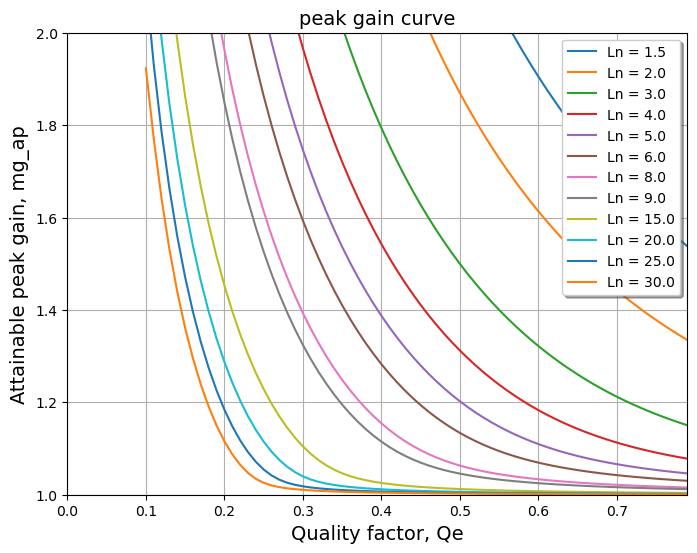

In [4]:
# The peak gain for curve inductance ratio Ln is to be ploted, 
# against the variation of load change represented by Qe
Ln_1 = [1.5, 2.0, 3.0,4.0,5.0, 6.0, 8.0, 9.0, 15, 20, 25, 30]
Qe_1 = np.arange(0.1, 0.8, 0.01)
fn_1 = np.arange(0.2,1,0.001)

pk_ind_1 = []
pks_1 = []
mg_ap_plt = plt.figure(figsize=(8,6))
ax_1 = mg_ap_plt.add_subplot(111)

# The loop is to obtain the peak gain values and visualize on a figure
# This figure is essential for selecting the suitable quality factor
for i, Ln_1_i in enumerate(Ln_1):
    for j, Qe_1_i in enumerate(Qe_1):
        Mgbyfn_1 = Mg(fn_1, Qe_1_i, Ln_1_i)
        pk_ind_temp1 = np.argmax(Mgbyfn_1)
        pk_ind_1.extend([pk_ind_temp1])
        pks_1.extend(Mgbyfn_1[np.array([pk_ind_temp1])])
        
    plt.plot(Qe_1, np.array(pks_1), label = f"Ln = {Ln_1_i:0.1f}")
    pk_ind_1 = []
    pks_1 = []

plt.legend(loc='upper right', shadow=True)
plt.ylim([1, 2])
plt.xlim([0,Qe_1[-1]])
plt.xlabel('Quality factor, Qe', fontsize=14)
plt.ylabel('Attainable peak gain, mg_ap', fontsize=14)
plt.title('peak gain curve', fontsize=14)
plt.grid(1,which='major') 

Tank impedance characteristic
-----------------------
The impedance is,

$$\begin{align}
Z_{in} &= \frac{V_{ge}}{I_{L_r}} \\
       &= \frac{1}{j\omega C_r} + j\omega L_r + j\omega L_m // R_e \\
       &= (\frac{1}{jf_n} + jf_n + \frac{jf_n L_n/Qe}{jf_n L_n + 1/Q_e})\cdot Z_r \\
       &= \sqrt{ \frac{1 + 
                    [{L_n}^2 {Q_e}^2 - 2(1 + L_n)] \cdot {f_n}^2 +
                    [(1+L_n)^2 - 2 {L_n}^2 {Q_e}^2] \cdot {f_n}^4 +
                    {L_n}^2 {Q_e}^2 \cdot {f_n}^6}
        {{f_n}^2 + {L_n}^2 {Q_e}^2 {f_n}^4}
        } \cdot Z_n
\end{align}$$
        
The curve of normalized input impedance $Z_{in} / Z_r$ is plotted. The negative slope means the impedance is capacitive, and positive slope inductive. The curves can be used to help judge the working zone.

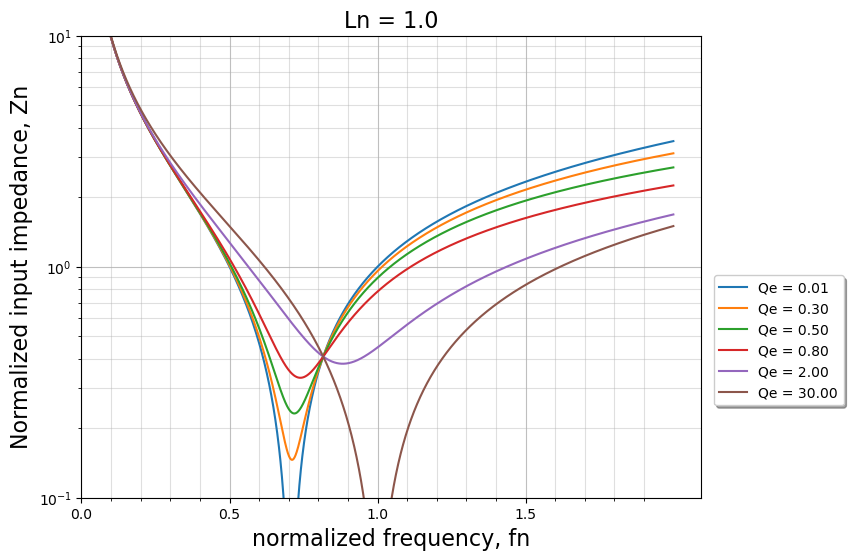

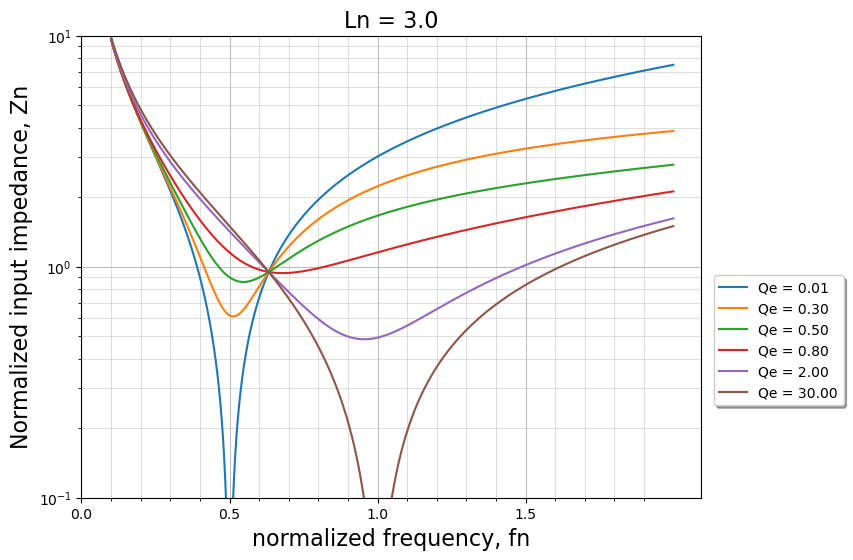

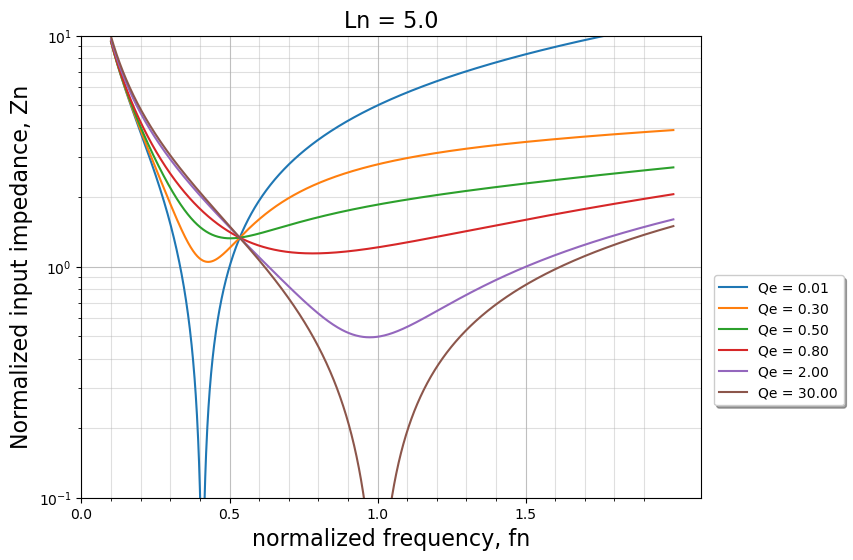

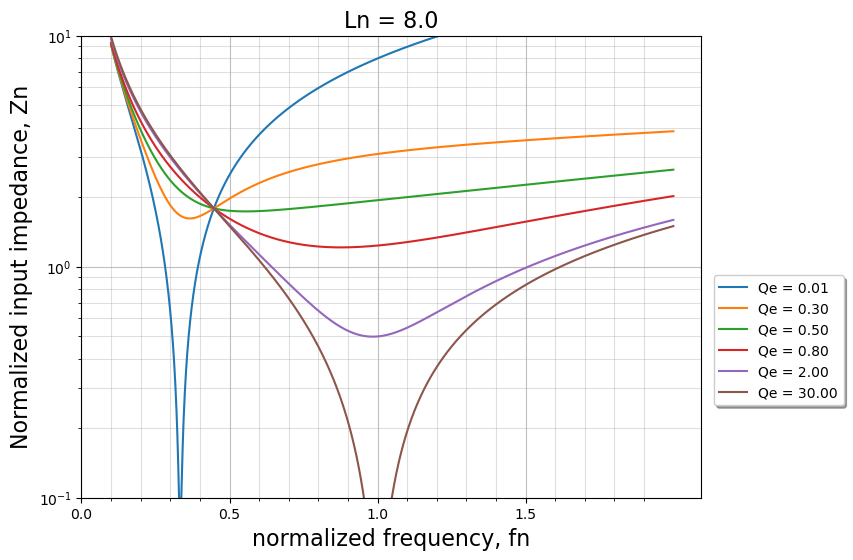

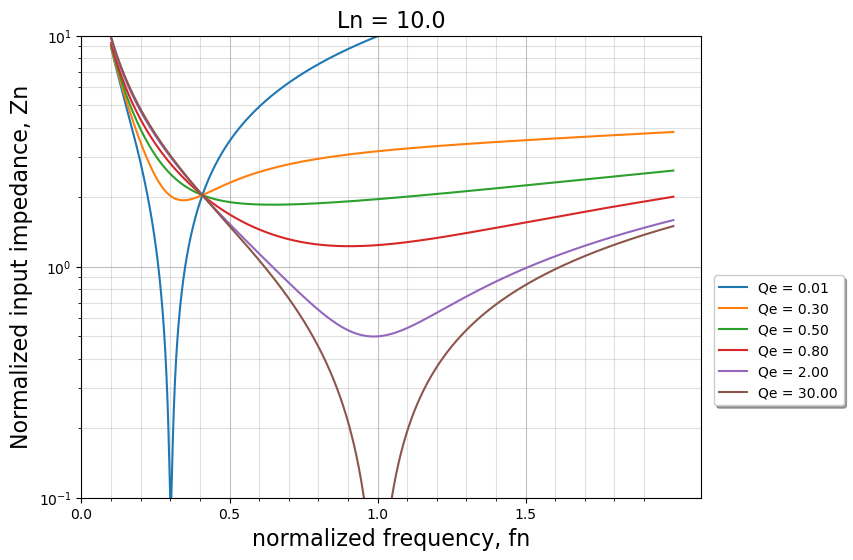

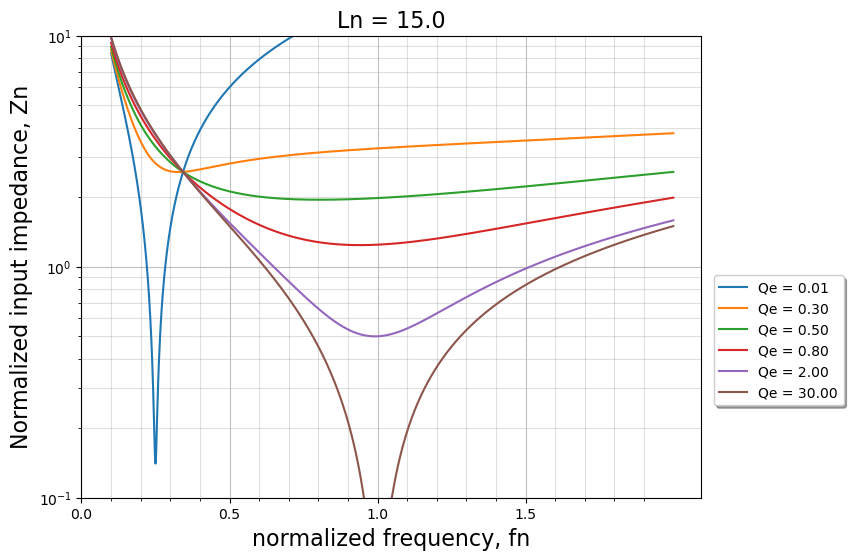

In [5]:
# Two form of Zn are writen below. They generate the same results

# form 1
# Zn = lambda fn,Qe,Ln: np.abs(1/(fn*1j) + fn*1j + fn*Ln/Qe * 1j / (fn*Ln*1j + 1/Qe))

# form 2
Zn = lambda fn,Qe,Ln: np.sqrt( (1 + (Ln**2 * Qe**2 - 2*(1 + Ln)) * fn**2 +
                    ((1+Ln)**2 - 2 * Ln**2 * Qe**2) * fn**4 +
                    Ln**2 * Qe**2 * fn**6) /
            (fn**2 + Ln**2 * Qe**2 * fn**4))

Qe = [0.01, 0.3, 0.5, 0.8, 2, 30]

# print (fn[:10], '\n', Ln, '\n', Qe)

for i, Ln_i in enumerate(Ln):
    plt1 = plt.figure(i+1,figsize=(8,6))
    ax = plt1.add_subplot(111)
    for j, Qe_j in enumerate(Qe):
        Znbyfn = Zn(fn,Qe_j,Ln_i)
        ax.semilogy(fn,Znbyfn,label = f"Qe = {Qe_j:.2f}")
        
    ax.set_title(f"Ln = {Ln_i:.1f}", fontsize=16)
    ax.set_ylim([0.1, 10])
#     plt.legend(loc='upper right', shadow=True)
    plt.legend(loc=(1.02,0.2), shadow=True, )
    ax.set_xlabel('normalized frequency, fn', fontsize=16)
    ax.set_ylabel('Normalized input impedance, Zn', fontsize=16)
    
    major_ticks = np.arange(0,fn[-1], 0.5)
    minor_ticks = np.arange(0,fn[-1], 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(1,which='both') 
    ax.grid(which='minor', alpha=0.4)
    ax.grid(which='major', alpha=0.8)


Resonant capacitor voltage
------------------
The capacitor voltage can be used to predict if the component selection is reasonable or not. 

$$\frac{V_{C_r}}{V_{ge}} = 
    \sqrt{ \frac {1 + {L_n}^2 {f_n}^2 {Q_e}^2}
    {1 + 
        [{L_n}^2 {Q_e}^2 - 2(1 + L_n)] \cdot {f_n}^2 +
        [(1+L_n)^2 - 2{L_n}^2 {Q_e}^2] \cdot {f_n}^4 +
        [{L_n}^2 {Q_e}^2] \cdot {f_n}^6}}$$

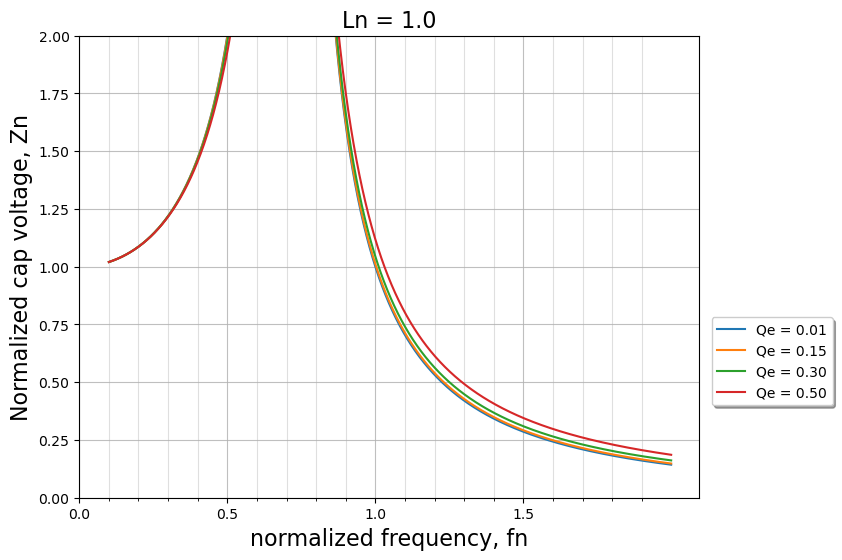

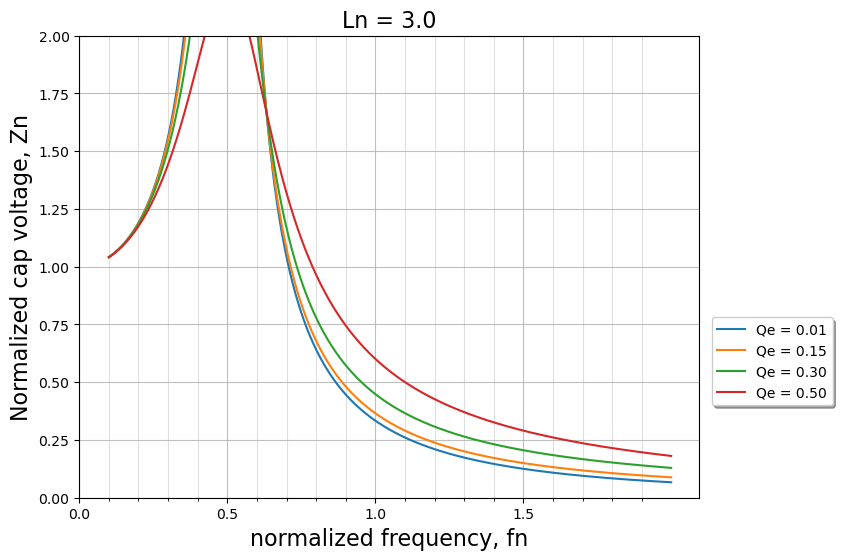

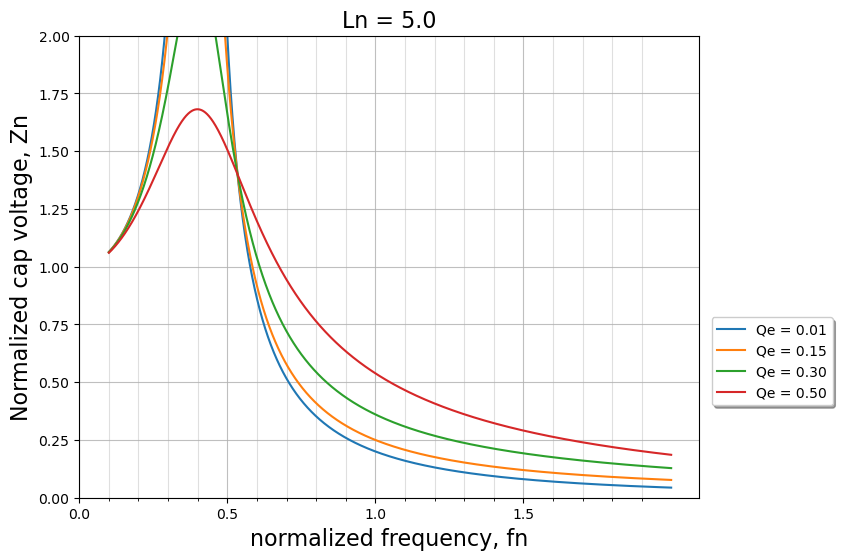

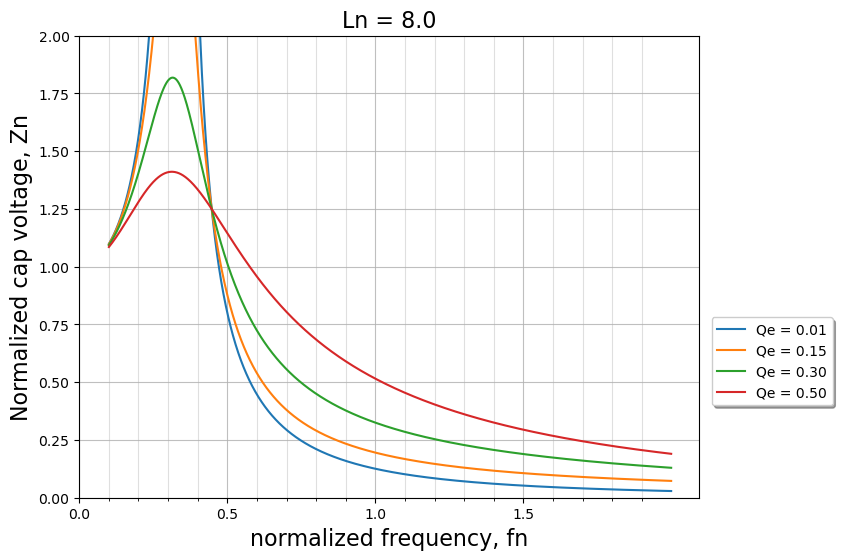

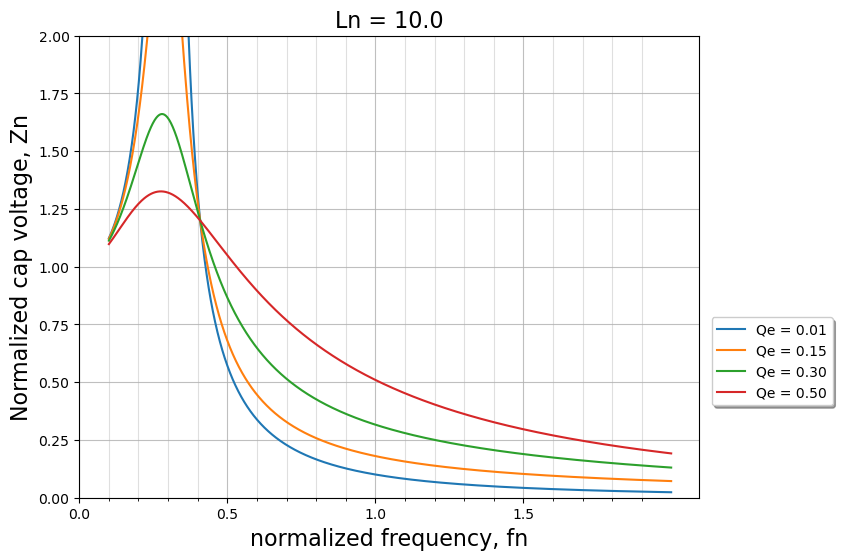

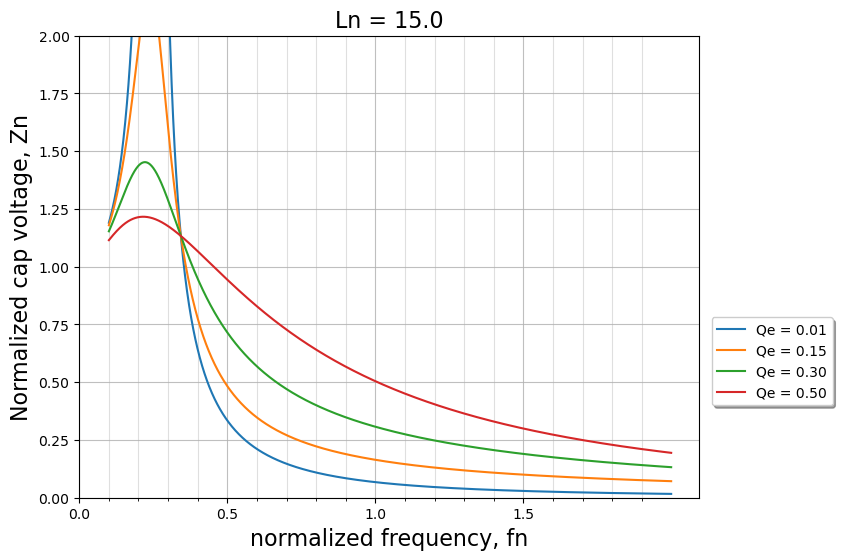

In [6]:
VCrn = lambda fn,Qe,Ln: np.sqrt( (1 + Ln**2 * fn**2 * Qe**2) /
    (1 + (Ln**2 * Qe**2 - 2*(1 + Ln)) * fn**2 +
        ((1+Ln)**2 - 2* Ln**2 * Qe**2) * fn**4 +
        Ln**2 * Qe**2 * fn**6))

Qe = [0.01, 0.15, 0.3, 0.5]

# print (fn[:10], '\n', Ln, '\n', Qe)

for i, Ln_i in enumerate(Ln):
    plt1 = plt.figure(i+1,figsize=(8,6))
    ax = plt1.add_subplot(111)
    for j, Qe_j in enumerate(Qe):
        VCrnbyfn = VCrn(fn, Qe_j, Ln_i)
#         ax.semilogx(fn,VCrnbyfn,label = f"Qe = {Qe_j:.2f}")
        ax.plot(fn,VCrnbyfn,label = f"Qe = {Qe_j:.2f}")
        
    ax.set_title(f"Ln = {Ln_i:.1f}", fontsize=16)
    ax.set_ylim([0.0, 2.0])
#     plt.legend(loc='upper right', shadow=True)
    plt.legend(loc=(1.02,0.2), shadow=True, )
    ax.set_xlabel('normalized frequency, fn', fontsize=16)
    ax.set_ylabel('Normalized cap voltage, Zn', fontsize=16)
    
    major_ticks = np.arange(0,fn[-1], 0.5)
    minor_ticks = np.arange(0,fn[-1], 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(1,which='both') 
    ax.grid(which='minor', alpha=0.4)
    ax.grid(which='major', alpha=0.8)

LLC resonant tank design
===========

This section focuses on designing the converter from scratch. Please proceed to the verification section if the LLC circuit parameters are already known and the purpose is only to validate parameters or to determine parameter settings. It's safe to skip this section under certain conditions when you may have to work with the existing configuration and don't have the authority to change the LLC circuit.

Some of the most challenging topics discussed in this section are how to choose key inputs to make trade-offs among various performance contradictions. Iterations may be required in the design process for parameter selection.

Design inputs
-----------
The inputs fall into two categories. The first is defined by the application, such as it's electrical requirements. The second category relates to the LLC resonant tank characteristics, which is crucial in determining the performance of LLC converters. Selecting inputs for this second category can be particularly challenging.

### The basic inputs
The basic inputs include the input/output voltage and loading conditions. 

In [7]:
Vin_max = 420
Vin = 390
Vin_min = 330
Vin_burst = 350

# 12v/3.5a, 16v/1.5a, 48v/1.6a
Vo = 12
Vo_burst = 11

Po_max = 3.5*Vo + 16*1.5 + 48*1.6
Po_min = Po_max/100

INTEG_XFMR = True

### Inductance ratio determination
The inductance ratio is one of the most critical input parameters that determines several key performance aspects of LLC converters.

* If the inductance ratio is too small (for instance, when $L_n = 1$), the circulating current is usually large, potentially resulting in low conversion efficiency.
* If the inductance ratio is too large (for example, when $L_n > 10$), the peak gain becomes much lower than that of smaller $L_n$ values, making it easier to enter the capacitive operation zone. Additionally, the gain curve becomes quite flat, leading to a very wide operation frequency range.

The inductance ratio $L_n$ is typically chosen between 4 and 8 as a trade-off between operation frequency range and conversion efficiency. In our case, $L_n = 5$ represents the best practice.

In [8]:
Ln = 5

# The theoretical minimum gain is calculated below,
# The gain must be higher than this limitation at the extreme low load and high bus voltage conditions. 
Mg_min = Ln/(Ln+1)
print( 'Mg_min = ', Mg_min )

Mg_min =  0.8333333333333334


### Frequencies determination

Set the **nominal operation frequency** 100kHz for this example design. 

As calculated above, the conversion gain must be higher than Mg_min to accommodate operation under all conditions. Therefore, the **resonant frequency** can be set slightly higher, e.g., 10% above the nominal operation frequency. The gain curve for frequencies higher than the resonant point is very flat. This resonant frequency selection also helps to narrow the frequency range.

On the other hand, the resonant point should not be significantly higher than the nominal operating frequency, as this might lead to the converter easily entering the capacitive mode zone.

In [9]:
fnom = 100e3
# The resonant frequency is purposely designed to be higher than the nominal frequency
# fr = 110e3
fr = 100e3

# fr = 1/(2*np.pi*np.sqrt(35e-6 * 30e-9))

fnom_pu = fnom/fr
print ('The resonant frequency is {}'.format(fr))
print('The normalized nominal frequency is {}'.format(fnom_pu))

The resonant frequency is 100000.0
The normalized nominal frequency is 1.0


### The effective turn ratio determination

**Note**: effective turn ratio is not physical turn ratio for integrated transformer.

The normal operation frequency should be decided first to determine the effective turn ratio. On the normalized gain curves, Q value is decided according to the location of nominal frequency and resonant frequency.

According to the output voltage equation,
$$V_{o}=M_g(f_n, L_n, Q_e)\times \frac{1}{n} \times \frac{V_{in}}{2}$$
The effective transformer turn ratio is calculated,

In [10]:
# Mg_fnom = 1.04  # obtain from the normalized gain curves
Mg_fnom = 1
# Mg_fnom = 1.15
n = Mg_fnom * Vin/2/Vo
print( 'The EFFECTIVE turn ratio (turn ratio of the ideal transformre) is:', n)

The EFFECTIVE turn ratio (turn ratio of the ideal transformre) is: 16.25


### Effective loading calculation
The equivalent resistance at maximum power could be obtained,

In [11]:
Rl_min = Vo**2/Po_max
Re_min = 8 * n**2 * Rl_min / np.pi**2 
print( 'The effective min loading resistance (at max load power):', Re_min, 'ohm')

The effective min loading resistance (at max load power): 215.83966431371954 ohm


### Quality factor selection

Like the inductance ratio $L_n$, $Q_e$ is another crucial input parameter.

Referring to the peak gain curves above, let's assume the inductance ratio $L_n$ has already been determined. 

Taking the $L_n=5$ curves as an example, the gain at the nominal operation point of $Q_e$ should be high enough to avoid easily entering the capacitive mode zone. Under step conditions, the effective load could be 3-5 times the nominal load. $Q_e$ actually represents the loading for a certain design, with ${Q_e}^2\propto{P_o}$. Thus, if we consider 3 times overloading, the gain at $1.732\times Q_{e,max}$ should also be high enough to avoid capacitive operation. 

$Q_{e,max}$ can be determined by considering all these factors.

In [12]:
# Qe_max = 0.15
Qe_max = 0.30


Resonant tank derivation
------------

With all the above parameters inputted and key values determined, it is now possible to deduce the LLC resonant tank working conditions. The resonant tank parameters can be calculated by solving the following three equations.

1. *Frequency normalized to the resonant frequency*: $f_n = \frac{f_{sw}}{f_0}$
2. *Inductance ratio*: $L_n = \frac{L_m}{L_r}$
3. *Quality factor*: $Q_e = \frac{\sqrt{{L_r}/{C_r}}}{R_e}$

In [13]:
def equations(p):
    Lr, Cr, Lm = p
    return (2 * np.pi * np.sqrt(Lr*Cr) * fr - 1, 
            Qe_max * Re_min - np.sqrt(Lr/Cr),
            Ln * Lr - Lm)

Lr, Cr, Lm = fsolve(equations, (10e-6, 15e-9, 500e-6))
print("Lr = {Lr:.4e} \nCr = {Cr:.4e} \nLm = {Lm:.4e}".format(Lr=Lr, Cr=Cr, Lm=Lm))

Lr = 1.0306e-04 
Cr = 2.4579e-08 
Lm = 5.1528e-04


In [14]:
# to round a usable capacitance
Cr = 12e-9 * 2

Qe_max = np.sqrt(Lr/Cr)/Re_min

print("Lr = {Lr:.4e} \nCr = {Cr:.4e} \nLm = {Lm:.4e}".format(Lr=Lr, Cr=Cr, Lm=Lm))
fr = 1/(2*np.pi* np.sqrt(Lr*Cr))

print("\nfr =", fr)
print("Re_min =", Re_min)
print("Qe_max =", Qe_max) 

Lr = 1.0306e-04 
Cr = 2.4000e-08 
Lm = 5.1528e-04

fr = 101199.45861240322
Re_min = 215.83966431371954
Qe_max = 0.30359837583705


Obtaining Real Windings and Expected Measured Inductances
---------------

It's readily apparent that the lumped leakage calculated above is distributed on both primary and secondary sides when measuring the parasitic inductances. This is primarily due to the intentionally loose coupling between the primary and secondary windings, resulting in a quite small coupling factor.

The calculated $L_r$, $L_m$, $C_r$, and the customer input parameters above are for the ideal LLC equivalent circuit, as shown below. (Figure courtesy of Yang Bo's dissertation).

![LLC equivalent circuit](./images/LLC-circuit.png "LLC equivalent circuit")

However, these equivalent inductances cannot be measured directly during the **integrated** transformer fabrication. What can be measured are the lumped parameters:

1. With the secondary windings open, the total primary inductance is obtained. This is actually the sum of the main inductance and parasitics by complex equivalent conversion.
2. With all secondary windings shorted, the equivalent leakage inductance converted to the primary side is obtained.

These are typically the parameters provided by the inductor fabricator. Therefore, we need to convert the LLC equivalent circuit parameters into values more understandable by inductor fabricators. This conversion is done by solving the equations below. The derivation is omitted for brevity.

In [15]:
if INTEG_XFMR:
    def equLls_eqtions(p):
        Lls_eq, Lm_eq, Llp_real = p
        return (Lm_eq+Llp_real-(Lm+Lr)*1e6, 
                Llp_real+Lls_eq/(Lls_eq/Lm_eq +1)-Lr*1e6, 
                Llp_real-Lr*1e6/4)

    Lls_eq,Lm_eq,Llp_real =  fsolve(equLls_eqtions, (55, 500, 1))

    print ("Llp_real =", Llp_real)
    print ("Lm_eq =", Lm_eq)
    print ("Lls_eq =", Lls_eq)

    r = Lls_eq/Lm_eq + 1
    print("\nratio scale", r)

    Ns = 3
    n_real = r*n
    Np = n_real*Ns
    print(Np)
    Np = np.round(Np)
    
    print("\nThe real turn ratio is {}".format(n_real))
    print("\nLm_meas ={Lm_meas: .3e} \nLr_meas ={Lr_meas: .3e} \nCr ={Cr: .3e}".format(Lm_meas = Lm+Lr, Lr_meas = Lr, Cr=Cr))
    print("Primary turn {Np}, the secondary turn {Ns}".format( Np=Np, Ns=Ns))

Llp_real = 25.76396211810432
Lm_eq = 592.5711287163992
Lls_eq = 88.88566930745992

ratio scale 1.1500000000000001
56.062500000000014

The real turn ratio is 18.687500000000004

Lm_meas = 6.183e-04 
Lr_meas = 1.031e-04 
Cr = 2.400e-08
Primary turn 56.0, the secondary turn 3


### Turn ratio adjustment
The turn ratio (Ns/Np) should be slightly higher to compensate for the deadtime duty loss. The dead time is 200ns in this application. The half period is about 5.5us (90hz operation frequency assumed), thus descrease the primary turn numbers a little bit to compensate the deadtime loss.

In [16]:
r_comp = 5000/(5000 - 200)
print ('\nThe turn ratio setting in the simulation: {}'.format(n * r_comp))

Np_adjust = n_real*Ns/r_comp

print( '\nThe EFFECTIVE turn ratio is:', n)
print ('Ns:', Ns, '\nNp_adjust:', Np_adjust)



The turn ratio setting in the simulation: 16.927083333333336

The EFFECTIVE turn ratio is: 16.25
Ns: 3 
Np_adjust: 53.82000000000001


Design Verification
==================
This verification process is intended to validate the parameters designed above.

Choosing Parameters
-------------
This section serves to verify both the design above and existing configurations. 

In some cases, the resonant tank may already be determined, and the purpose is to validate existing parameters or deduce VCO values. This script allows the use of existing parameters to override the designed values for verification purposes.

* Commenting out the following settings means we use the resonant tank parameters from the design above for verification.
* Input ALL the parameters as required by the example for existing resonant tank verification.

If the resonant tank is already known, then $Lm_{eq}$, $Lls_{eq}$, and the physical turn ratio are given in the inductor specifications. To obtain the LLC equivalent circuit parameters, we can reverse-solve the equations used to obtain the measured inductance. This straightforward calculation is omitted here.

In [17]:
print ("===== designed transformer ======")
print(f"Lr = {Lr:.3e} \nCr = {Cr:.3e} \nLm = {Lm:.3e}")
print(f"fr = {fr}")
print(f"Qe_max = {Qe_max}") 
print(f"Re_min = {Re_min}")
print('\n')

enable_dpc = 0
    
### transformer winding ratio 29:3-1
if 0:
    Vo = 24
    Vo_burst = 22
    if enable_dpc:
        Vo_dpc = 22
    Lr = 44e-6
    Cr = 44e-9
    Lm = 198e-6
    Ln = Lm/Lr
    fr = 1/(2*np.pi* np.sqrt(Lr*Cr))
    n = 8.28571428571
    
    Po_max = Vo*16
    Rl_min = Vo**2/Po_max
    Re_min = 8 * n**2 * Rl_min / np.pi**2 
    Qe_max = np.sqrt(Lr/Cr)/Re_min
    
print (f"===== existing transformer ======")
print(f"Lr = {Lr:.3e} \nCr = {Cr:.3e} \nLm = {Lm:.3e}")
print(f"Ln={Ln}")
print(f"fr ={fr}")
print(f"Qe_max = {Qe_max}") 
print(f"Re_min = {Re_min}")

===== designed transformer ======
Lr = 1.031e-04 
Cr = 2.400e-08 
Lm = 5.153e-04
fr = 101199.45861240322
Qe_max = 0.30359837583705
Re_min = 215.83966431371954


===== existing transformer ======
Lr = 1.031e-04 
Cr = 2.400e-08 
Lm = 5.153e-04
Ln=5
fr =101199.45861240322
Qe_max = 0.30359837583705
Re_min = 215.83966431371954


Typical operation points
--------------------
The operation point is essential to identifying the real characteristics. The major gains on different typical operation point are calculated.

In [18]:
Mg_nom = Vo*n*2 / Vin
Mg_min = Vo*n*2 / Vin_max
Mg_max = Vo*n*2 / Vin_min
Mg_burst_min = Vo_burst*n*2 / Vin
Mg_burst_nom = Vo_burst*n*2 / Vin_burst

print(f'The nominal gain is: {Mg_nom}')
print(f'The minimum gain is: {Mg_min}')
print(f'The maximum gain is: {Mg_max}')

if enable_dpc:
    Mg_dpc = Vo_dpc*n*2/ Vin
    print(f'The dpc gain is: {Mg_dpc}')

The nominal gain is: 1.0
The minimum gain is: 0.9285714285714286
The maximum gain is: 1.1818181818181819


Gain curve verification
-----------------
The gain curves on different operation conditions and the typical operation gain point are plotted on the same figure, which provides insight to the operation characteristics of the converter.

LLC has this relationship of quality factor and the loading power: $Q_e \propto \frac{1}{R_e}$, $P_o \propto \frac{1}{{R_e}^2}$, thus, $P_o \propto {Q_e}^2$. The normalized gain curves are obtained. The power is normalized to be based on the maximum designed power. 

Qe_scale = [1.   1.75 2.5  3.25 4.  ]
Qe = [0.30359838 0.17348479 0.12143935 0.09341488 0.07589959]


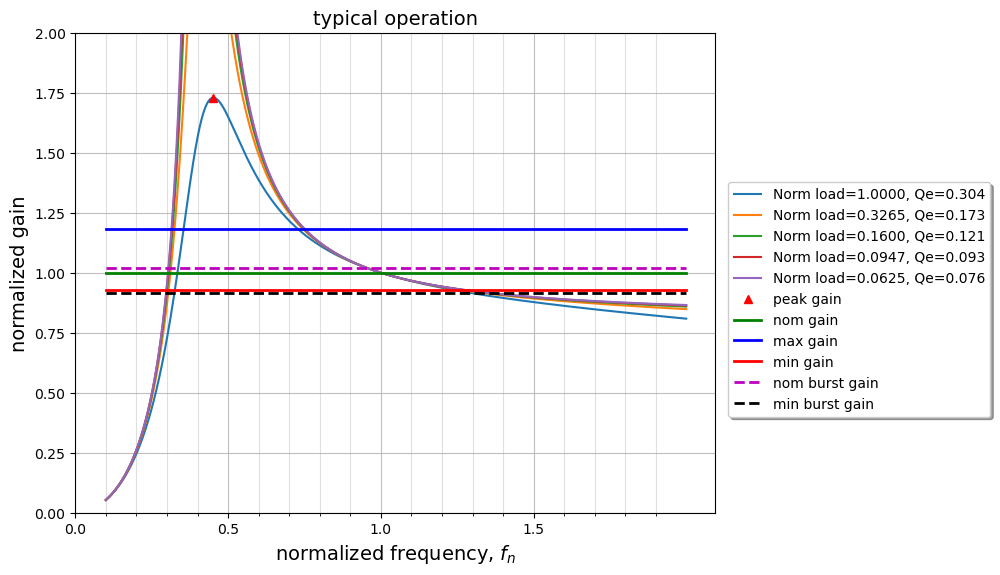

In [19]:
# rewrite the gain function here
Mg = lambda fn,Qe,Ln: np.abs((Ln*fn*fn)/(((Ln+1)*fn*fn - 1) + (fn*fn -1)*fn*Qe*Ln*1j))

# The resonant tank and the basic application condition is already know,
# so we only need to test the gain curves over frequency on different load conditions
fn = np.arange(0.1, 2, 0.001)

Qe_scale = np.linspace(1,4,5)
# Qe_scale = np.insert(Qe_scale, 0, [np.sqrt(1.0/3), np.sqrt(0.5)])

print(f'Qe_scale = {Qe_scale}')
Qe = Qe_max/ Qe_scale
print(f'Qe = {Qe}')

pk_ind = []  # index of the peak gain point
pks = []

plt1 = plt.figure(figsize=(8,6))
ax1_1 = plt1.add_axes([0.1,0.1,0.8,0.8])

for j, Qe_j in enumerate(Qe):
    Mg_by_fn = Mg(fn,Qe[j],Ln)
    #ax1_1.semilogx(fn,Mg_by_fn,label = "Qe = %.4f"%Qe[j])
    # plot the gain curve
    ax1_1.plot(fn,Mg_by_fn,label = f"Norm load={1/Qe_scale[j]**2:.4f}, Qe={Qe_j:.3f}")
    pk_ind_temp = np.argmax(Mg_by_fn)
    pk_ind.extend( [pk_ind_temp] )
    pks.extend( Mg_by_fn[np.array([pk_ind_temp])] )

ax1_1.plot(fn[np.array(pk_ind)], np.array(pks),'r^', label="peak gain" )  # plot the peak gain point
ax1_1.plot([fn[0],fn[-1]], [Mg_nom,Mg_nom], 'g-', lw=2, label="nom gain") # plot the nonimal gain required

ax1_1.plot([fn[0],fn[-1]], [Mg_max,Mg_max], 'b-', lw=2, label="max gain") # plot the maximum gain required
ax1_1.plot([fn[0],fn[-1]], [Mg_min,Mg_min], 'r-', lw=2, label="min gain")  # plot the minimum gain required
if enable_dpc == 0:
    ax1_1.plot([fn[0],fn[-1]], [Mg_burst_nom,Mg_burst_nom], 'm--', lw=2, label="nom burst gain")
    ax1_1.plot([fn[0],fn[-1]], [Mg_burst_min,Mg_burst_min], 'k--', lw=2, label="min burst gain")
if enable_dpc:
    ax1_1.plot([fn[0],fn[-1]], [Mg_dpc,Mg_dpc], 'm--', lw=2, label="DOP gain")

# ax1_1.set_xlim([0.77, 0.82])
# ax1_1.set_ylim([1.1, 1.2])
ax1_1.set_ylim([0,2])
plt.legend(loc=(1.02,0.2), shadow=True, )

ax1_1.set_title('typical operation', fontsize=14)
ax1_1.set_xlabel('normalized frequency, $f_n$', fontsize=14)
ax1_1.set_ylabel('normalized gain', fontsize=14)

major_ticks = np.arange(0,fn[-1], 0.5)
minor_ticks = np.arange(0,fn[-1], 0.1)
ax1_1.set_xticks(major_ticks)
ax1_1.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(major_ticks)
#ax.set_yticks(minor_ticks, minor=True)
ax1_1.grid(which='both')
ax1_1.grid(which='minor', alpha=0.4)
ax1_1.grid(which='major', alpha=0.8)